<h2>Determine the range of ToT for which you want to look at dark rate counts for</h2>

Time Interval for the whole run: 13312869407740.625 ps
Number of filtered ToT values: 8171


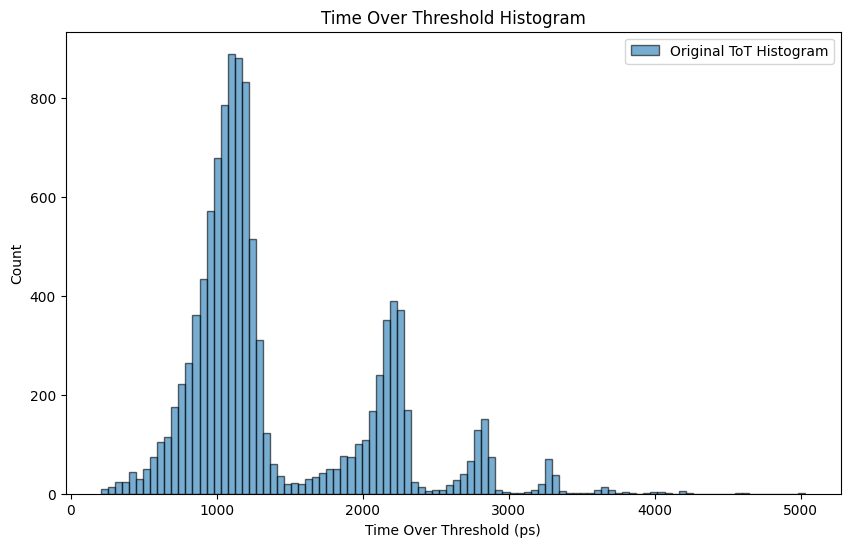

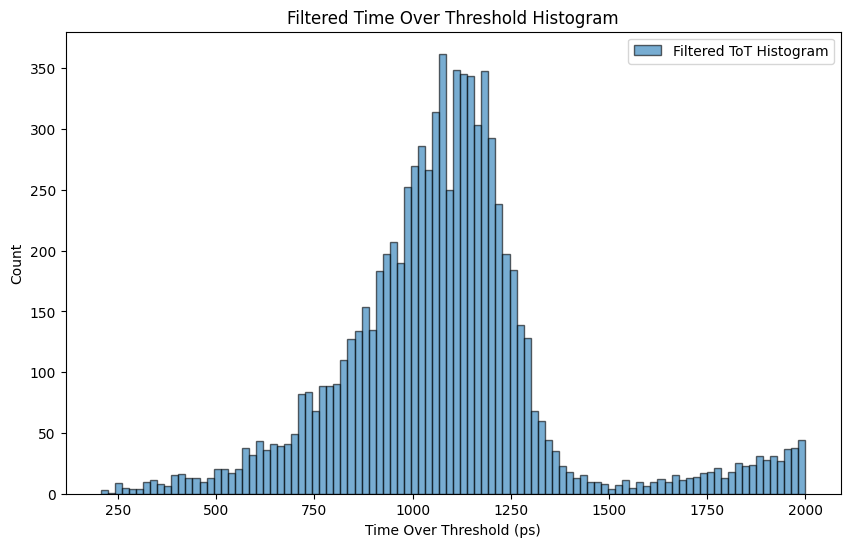

In [1]:
import sys
import midas.file_reader
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Path to the MIDAS file
fpath = "C:/Users/Lenovo/Documents/TRIUMF General Fusion/run00089_0000.mid.lz4"
mfile = midas.file_reader.MidasFile(fpath, use_numpy=True)

# Function to convert ADC value to time in picoseconds
def adc2time(adcvalue):
    return adcvalue * 3.125  # each count is 3.125 ps

# Function to parse a 64-bit word into its components
def parse_hit_word(word):
    channel_id = (word >> 56) & 0xFF
    edge = (word >> 48) & 0xFF
    tot = (word >> 32) & 0xFFFF
    toa = word & 0xFFFFFFFF
    return channel_id, edge, tot, toa

# Lists to store leading and trailing edges
leading_edges = []
trailing_edges = []

prev_edge = None

# Iterate over all events in the file
for event in mfile:
    if event.header.is_midas_internal_event():
        continue

    if event.header.serial_number > 10000:
        break

    for bank_name in event.banks:
        bank = event.banks[bank_name]
        data = bank.data
        index = 0
        
        while index < len(data):
            # Read header words
            trigger_timestamp = data[index]
            trigger_id = int(data[index + 1])
            header_word2 = int(data[index + 2])
            board_number = (header_word2 >> 32) & 0xFFFFFFFF
            number_of_hits = header_word2 & 0xFFFFFFFF
            
            if trigger_id > 1163400:
                index += 3 + number_of_hits
                continue

            index += 3  # Move past the header words
            
            # Read hit words
            for _ in range(number_of_hits):
                hit_word = int(data[index])
                channel_id, edge, tot, toa = parse_hit_word(hit_word)
                
                if channel_id == 2:
                    ts_ps = adc2time(toa) + trigger_timestamp*12800

                    if edge == 1:  # leading edge
                        if prev_edge == edge:
                            leading_edges[-1] = ts_ps
                        else:
                            leading_edges.append(ts_ps)
                    elif edge == 0:  # trailing edge
                        if prev_edge != edge and len(leading_edges) > len(trailing_edges) and ts_ps >= leading_edges[-1]:
                            trailing_edges.append(ts_ps)
                
                    prev_edge = edge
                index += 1

# Ensure the leading_edges and trailing_edges arrays are of the same length
min_length = min(len(leading_edges), len(trailing_edges))
leading_edges = np.array(leading_edges[:min_length])
trailing_edges = np.array(trailing_edges[:min_length])

# Calculate Time Over Threshold (ToT)
tot = trailing_edges - leading_edges

# Define the ToT range
tot_min = 0  # Example minimum ToT value in picoseconds
tot_max = 2000  # Example maximum ToT value in picoseconds

# Filter leading and trailing edges based on ToT range
filtered_leading_edges = []
filtered_trailing_edges = []

for le, te in zip(leading_edges, trailing_edges):
    if tot_min <= (te - le) <= tot_max:
        filtered_leading_edges.append(le)
        filtered_trailing_edges.append(te)

# Calculate the time interval for the whole run
if leading_edges.size > 0:
    time_interval = max(leading_edges) - min(leading_edges)
else:
    time_interval = 0

# Store filtered leading and trailing edges in arrays
filtered_leading_edges = np.array(filtered_leading_edges)
filtered_trailing_edges = np.array(filtered_trailing_edges)

# Print the results
print(f"Time Interval for the whole run: {time_interval} ps")
print(f"Number of filtered ToT values: {len(filtered_leading_edges)}")

# Plot the original ToT histogram
plt.figure(figsize=(10, 6))
plt.hist(tot, bins=100, edgecolor='black', alpha=0.6, label='Original ToT Histogram')
plt.title("Time Over Threshold Histogram")
plt.xlabel("Time Over Threshold (ps)")
plt.ylabel("Count")
plt.legend()
plt.show()

# Calculate the filtered ToT
filtered_tot = filtered_trailing_edges - filtered_leading_edges

# Plot the filtered ToT histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_tot, bins=100, edgecolor='black', alpha=0.6, label='Filtered ToT Histogram')
plt.title("Filtered Time Over Threshold Histogram")
plt.xlabel("Time Over Threshold (ps)")
plt.ylabel("Count")
plt.legend()
plt.show()


<h2>Calculating the dark noise rate for this range </h2>

In [20]:
# Calculate the rate
num_filtered_tot_values = len(filtered_leading_edges)
rate = num_filtered_tot_values / (time_interval * 1e-12)  # Convert picoseconds to seconds

# Print the rate
print(f"Rate: {rate} events per second")


Rate: 350.5034905812198 events per second


<h2>Now storing the range value in a list, to be plotted. This list updates each time you run the block of code below. I used this to store values of dark rates for the same p.e peak range but different overvoltages. (i.e looking at 3 p.e data for overvoltages of 4,6,8 and 12 V overvoltage) </h2>

In [21]:
# Ensure the list is not re-initialized if the cell is run multiple times
try:
    rate_list
except NameError:
    rate_list = []

def update_rate_list(new_rate):
    global rate_list
    rate_list.append(new_rate)
    print(f"Updated Rate List: {rate_list}")

update_rate_list(rate)



Updated Rate List: [2.3840413849613338, 30.371113694368304, 71.48531146114472, 350.5034905812198]


<h2>Finally, plotting different dark rates against overvoltages </h2>

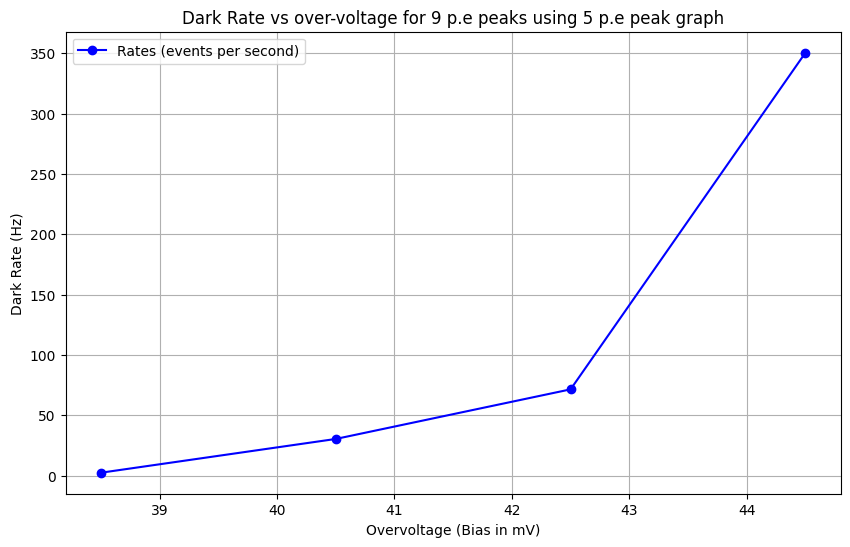

In [23]:
import matplotlib.pyplot as plt

# Ensure the list is not re-initialized if the cell is run multiple times
try:
    rate_list
except NameError:
    rate_list = []

#rate_list=[39, 301, 1263, 3687]
# X-values for plotting
x_values = [38.5, 40.5, 42.5, 44.5]

# Ensure there are enough x-values for the rates in rate_list
if len(rate_list) > len(x_values):
    x_values.extend(range(x_values[-1] + 1, x_values[-1] + 1 + len(rate_list) - len(x_values)))

# Plot the rate_list against x_values
plt.figure(figsize=(10, 6))
plt.plot(x_values[:len(rate_list)], rate_list, marker='o', linestyle='-', color='b', label='Rates (events per second)')
plt.title("Dark Rate vs over-voltage for 9 p.e peaks using 5 p.e peak graph")
plt.xlabel("Overvoltage (Bias in mV)")
plt.ylabel("Dark Rate (Hz)")
plt.legend()
plt.grid(True)
plt.show()


<h2>Now plotting various dark rate vs overvoltage bias plots together </h2>

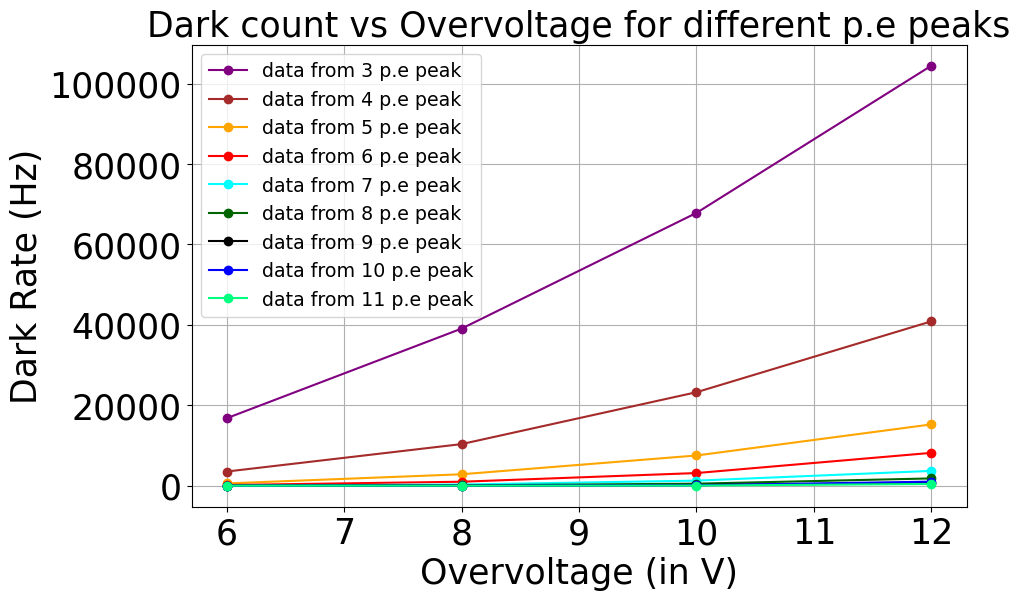

In [24]:
import matplotlib.pyplot as plt

# Data for the graph
x = [6, 8, 10, 12]
three_pe = [16788, 39070, 67843, 104444]
four_pe = [3527, 10351, 23253, 40876 ]
five_pe = [569, 2847, 7519, 15249]
six_pe = [175, 995, 3151, 8172]
seven_pe = [9, 301, 1263, 3687]
eight_pe = [11, 96, 509, 1817]
nine_pe = [6, 31, 193, 702]
ten_pe = [2, 31, 100, 1016]
eleven_pe = [0.56, 13, 39, 438]

# Plotting the graph with increased font size
plt.figure(figsize=(10, 6))
plt.plot(x, three_pe, marker='o', linestyle='-', color='purple', label='data from 3 p.e peak')
plt.plot(x, four_pe, marker='o', linestyle='-', color='brown', label='data from 4 p.e peak')
plt.plot(x, five_pe, marker='o', linestyle='-', color='orange', label='data from 5 p.e peak')
plt.plot(x, six_pe, marker='o', linestyle='-', color='red', label='data from 6 p.e peak')
plt.plot(x, seven_pe, marker='o', linestyle='-', color='cyan', label='data from 7 p.e peak')
plt.plot(x, eight_pe, marker='o', linestyle='-', color='darkgreen', label='data from 8 p.e peak')
plt.plot(x, nine_pe, marker='o', linestyle='-', color='black', label='data from 9 p.e peak')
plt.plot(x, ten_pe, marker='o', linestyle='-', color='blue', label='data from 10 p.e peak')
plt.plot(x, eleven_pe, marker='o', linestyle='-', color='springgreen', label='data from 11 p.e peak')

# Increasing font sizes
plt.title('Dark count vs Overvoltage for different p.e peaks', fontsize=25)
plt.xlabel('Overvoltage (in V)', fontsize=25)
plt.ylabel('Dark Rate (Hz)', fontsize=25)
plt.legend(fontsize=13.7)

# Increasing tick label size
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# Display the plot
plt.grid(True)
plt.show()


<h2>For some runs, I same p.e data for different thresholds. I.e I got 5 p.e data from setting the TDC threshold for 3 p.e peaks, but also then while setting it specifically for 5 p.e peaks. This is now the comparison of that data. </h2>

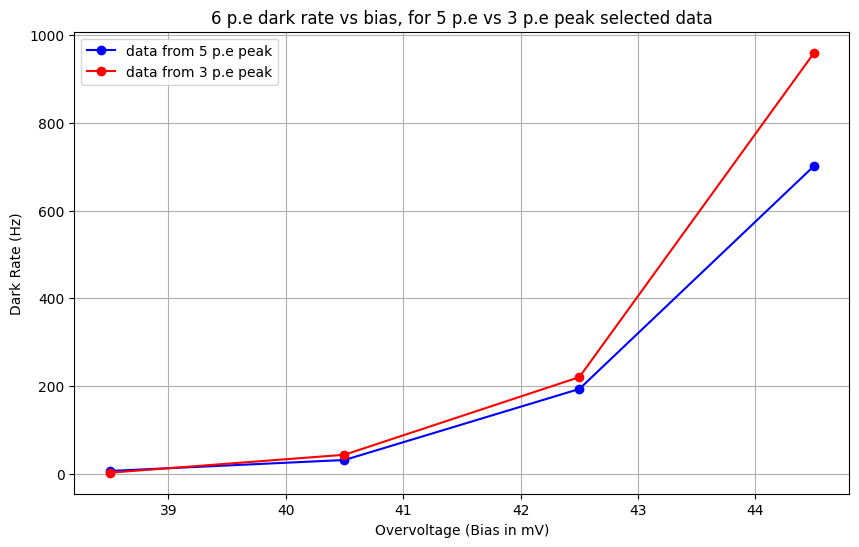

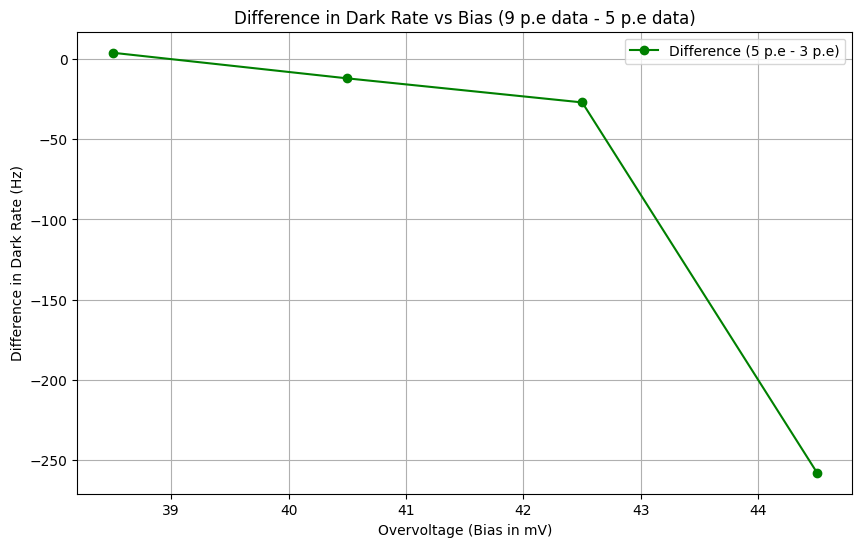

In [3]:
import matplotlib.pyplot as plt

# Data for the graph
x = [38.5, 40.5, 42.5, 44.5]
y1 = [6, 31, 193, 702]
y2 = [2, 43, 220, 960]

# Calculating the difference between y1 and y2
y_diff = [y1[i] - y2[i] for i in range(len(y1))]

# Plotting the original data
plt.figure(figsize=(10, 6))
plt.plot(x, y1, marker='o', linestyle='-', color='b', label='data from 5 p.e peak')
plt.plot(x, y2, marker='o', linestyle='-', color='r', label='data from 3 p.e peak')

# Adding titles and labels
plt.title('6 p.e dark rate vs bias, for 5 p.e vs 3 p.e peak selected data')
plt.xlabel('Overvoltage (Bias in mV)')
plt.ylabel('Dark Rate (Hz)')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

# Plotting the difference on a separate plot
plt.figure(figsize=(10, 6))
plt.plot(x, y_diff, marker='o', linestyle='-', color='g', label='Difference (5 p.e - 3 p.e)')

# Adding titles and labels
plt.title('Difference in Dark Rate vs Bias (9 p.e data - 5 p.e data)')
plt.xlabel('Overvoltage (Bias in mV)')
plt.ylabel('Difference in Dark Rate (Hz)')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()
